In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string

In [16]:
# Compute inertia and assign labels to closest centroid
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances

def compute_inertia_and_labels(centroids, data, threshold=100000, distance_metric='manhattan'):
    # Choose distance metric
    if distance_metric == 'euclidean':
        distances = euclidean_distances(data, centroids)
    elif distance_metric == 'manhattan':
        distances = manhattan_distances(data, centroids)
    else:
        raise ValueError("Unsupported distance metric. Choose 'euclidean' or 'manhattan'.")

    labels = np.argmin(distances, axis=1)
    min_distances = np.min(distances, axis=1)

    # Assign -1 for distances greater than threshold
    labels[min_distances > threshold] = -1

    # Compute inertia for assigned data points
    assigned_data_points = data[labels != -1]
    if len(assigned_data_points) > 0:
        assigned_labels = labels[labels != -1]
        inertia = np.sum((assigned_data_points - centroids[assigned_labels]) ** 2)
    else:
        inertia = 0

    # Calculate additional metrics if needed
    num_outliers = np.sum(labels == -1)
    average_distance = np.mean(min_distances[labels != -1]) if len(assigned_data_points) > 0 else 0

    return inertia

In [17]:
class Cuckoo:
    def __init__(self, data, n_clusters):
        self.position = data[np.random.choice(data.shape[0], n_clusters, replace=False), :]
        self.fitness= compute_inertia_and_labels(self.position, data)


In [12]:
def cuckoo_kmeans(data, n_clusters, n_nests=10, max_iter=100, pa=0.25,kmeans_interval=20):
    cuckoos = [Cuckoo(data, n_clusters) for _ in range(n_nests)]

    for _ in range(max_iter):
        for cuckoo in cuckoos:
            # Generate new solution and calculate its fitness
            new_position = cuckoo.position + np.random.uniform(-1, 1, cuckoo.position.shape)
            new_fitness = compute_inertia_and_labels(new_position, data)

            # Randomly choose a nest
            random_nest = np.random.choice(cuckoos)

            # Replace the worst solution with the new one if it's better
            if new_fitness < random_nest.fitness:
                random_nest.position = new_position
                random_nest.fitness = new_fitness

        # Abandon worse nests and build new ones
        cuckoos.sort(key=lambda x: x.fitness)
        n_abandon = int(n_nests * pa)
        for i in range(n_abandon, n_nests):
            cuckoos[i] = Cuckoo(data, n_clusters)
        if i % kmeans_interval == 0 and i != 0:
            # Using current global best as initial centroids for KMeans refinement
            kmeans = KMeans(n_clusters=n_clusters, init=global_best_position, n_init=1)
            kmeans.fit(data)
            refined_centroids = kmeans.cluster_centers_

            # Update global best if KMeans refinement improves inertia
            refined_inertia, _ = compute_inertia_and_labels(refined_centroids, data)
            if refined_inertia < global_best_score:
                global_best_score = refined_inertia
                global_best_position = refined_centroids

    best_nest = cuckoos[0]
    final_kmeans = KMeans(n_clusters=n_clusters, init=np.array(best_nest.position), n_init=1, max_iter=300)
    final_kmeans.fit(data)
    return final_kmeans

In [13]:
nltk.download('stopwords')
nltk.download('punkt')

# Initialize stopwords, stemmer, and punctuation set
stop_words = set(stopwords.words('english'))
punctuation_set = set(string.punctuation)
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to C:\Users\Devendra
[nltk_data]     Nemade\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Devendra
[nltk_data]     Nemade\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text)
    # Convert to lowercase, remove punctuation, remove stopwords, and stem
    processed_tokens = [stemmer.stem(word.lower()) for word in tokens if word.lower() not in stop_words and word not in punctuation_set]
    # Re-join processed tokens into a single string
    return ' '.join(processed_tokens)

In [7]:
newsgroups_dataset = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), random_state=42)

In [8]:
processed_data = [preprocess_text(doc) for doc in newsgroups_dataset.data]
# Use TfidfVectorizer to convert the raw text into TF-IDF features
print("Vectorizing the text data...")
tfidf_vectorizer = CountVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_data)
n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)
tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)


Vectorizing the text data...


In [9]:
if tfidf_matrix_reduced.dtype == 'float64':
    tfidf_matrix_reduced = tfidf_matrix_reduced.astype('float32')

In [18]:
n_clusters = 2
kmeans = cuckoo_kmeans(tfidf_matrix_reduced, n_clusters)
print("Cluster centers:", kmeans.cluster_centers_)
print("Labels:", kmeans.labels_)



Cluster centers: [[ 3.7103915e-01  1.5043402e+02 -2.2999253e+00  1.7436140e+01
   1.9317678e+01  1.0678724e+01  1.5025468e+01  6.5548806e+00
  -1.6510792e+01  1.0241613e+01 -1.8296959e-01  1.5059029e+00
   2.0760646e-01 -6.1504526e+00  6.0491157e-01  3.6695149e+00
   2.2201290e+00 -1.5000100e+00  7.7228503e+00 -5.7213387e+00
  -2.8997340e+00 -1.3569514e+00  1.0879663e+00 -1.7501888e+00
   4.2570405e+00  4.9630129e-01 -4.7458949e+00  2.1408985e+00
  -3.4304887e-01 -2.6635094e+00  8.2929456e-01  2.7101153e-01
   1.1682240e+00  5.1376276e+00  5.7715893e-01  2.3275743e+00
   9.1570139e-01  6.5418953e-01 -2.0846090e+00  6.4736813e-01
   1.3431039e+00  8.7236661e-01 -8.5136682e-01 -2.5688233e+00
  -2.4967663e-01 -1.1947513e+00 -1.7347724e+00 -1.1815265e+00
  -5.5160797e-01  5.1119685e-01  3.6278436e-01  1.0054215e+00
  -2.2784867e+00  4.9136147e-01  4.6799460e-01  2.5904140e+00
   2.1216364e+00  1.9826660e-01 -1.6340792e+00  8.7456268e-01
   7.6890177e-01  2.9186821e-01  8.1170708e-01 -1.522

In [19]:
silhouette = silhouette_score(tfidf_matrix_reduced, kmeans.labels_)
davies_bouldin = davies_bouldin_score(tfidf_matrix_reduced, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(tfidf_matrix_reduced, kmeans.labels_)


print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

Silhouette Score: 0.9631608128547668
Davies-Bouldin Index: 1.7546589479159556
Calinski-Harabasz Index: 30.13374865453222


0.9611051


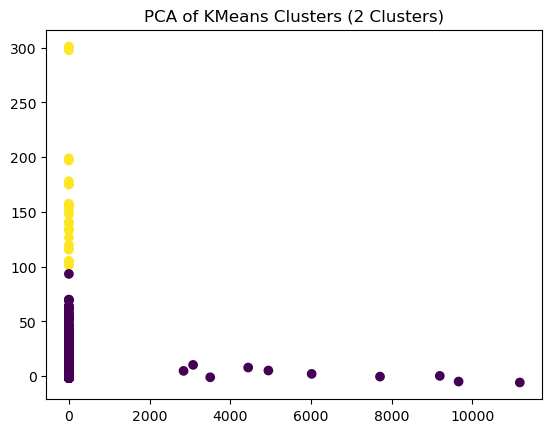

0.97161764


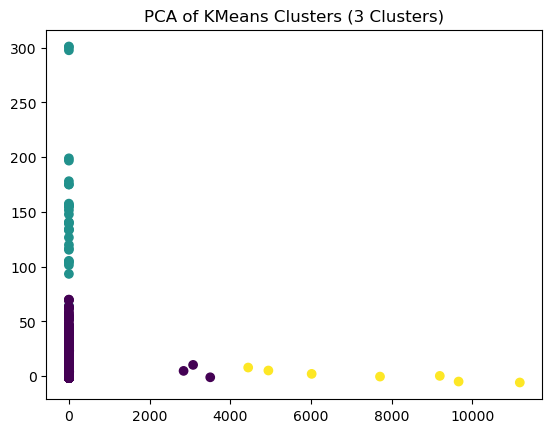

0.98000956


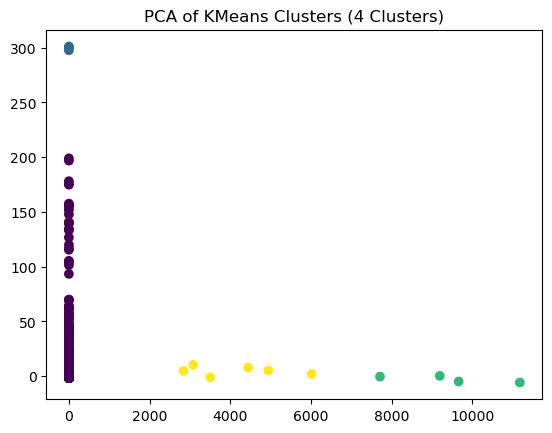

0.96021247


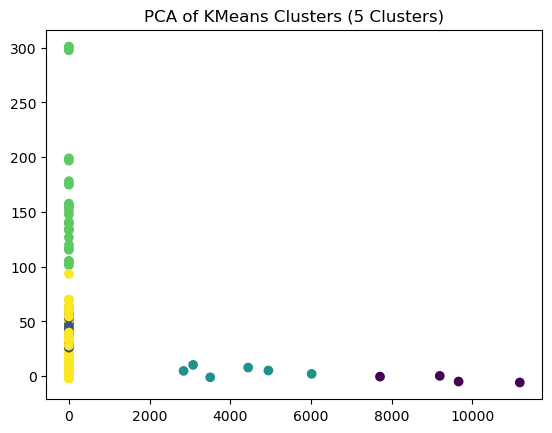

0.88260543


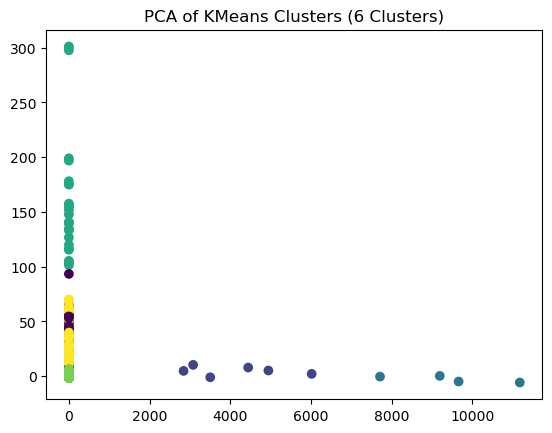

0.8803155


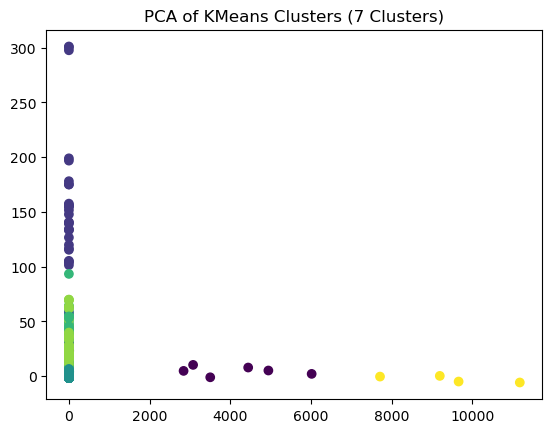

0.76333827


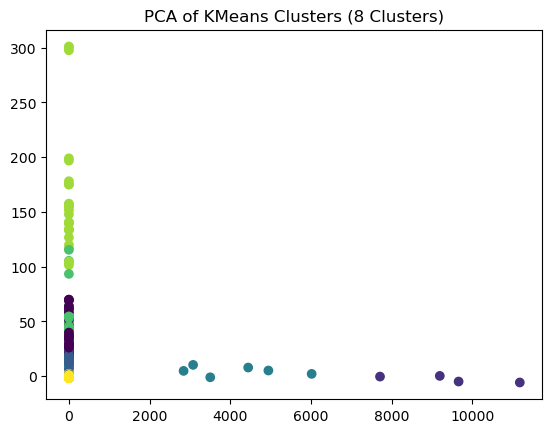

0.69021946


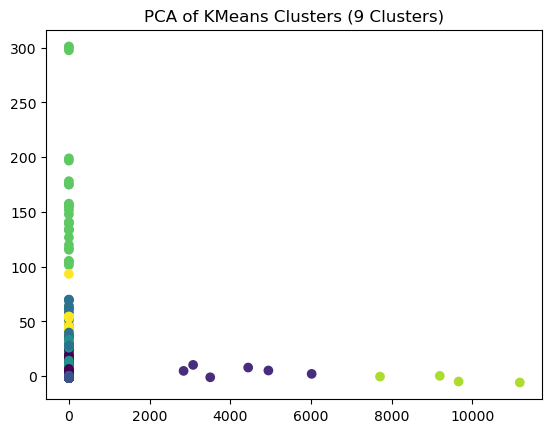

0.7125776


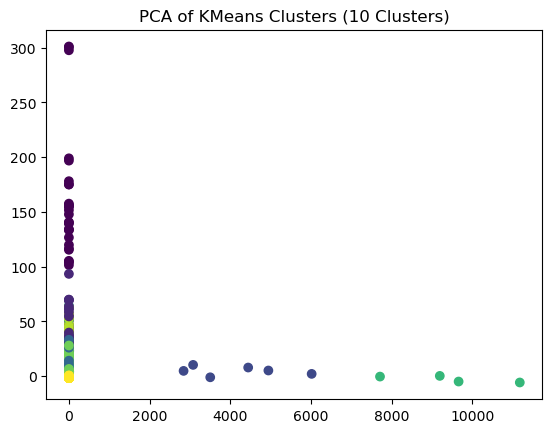

0.7657409


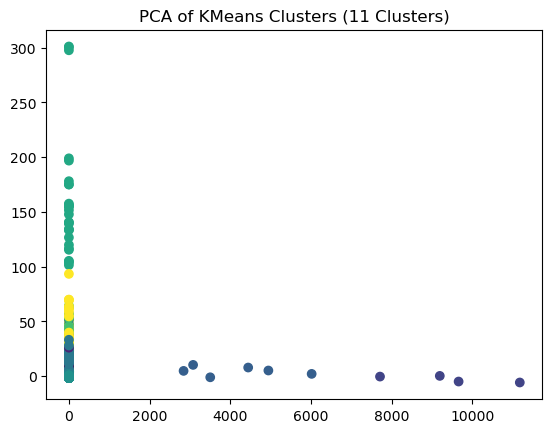

0.68950206


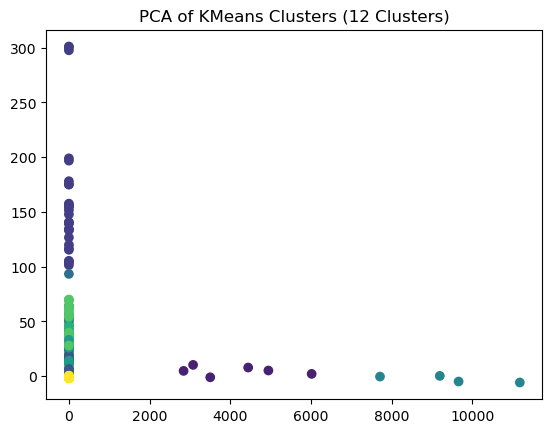

0.6201777


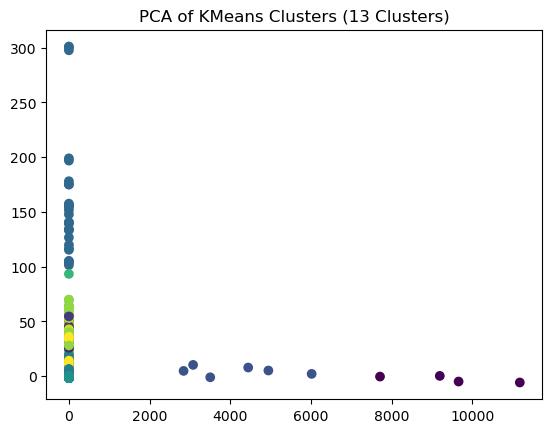

0.6606586


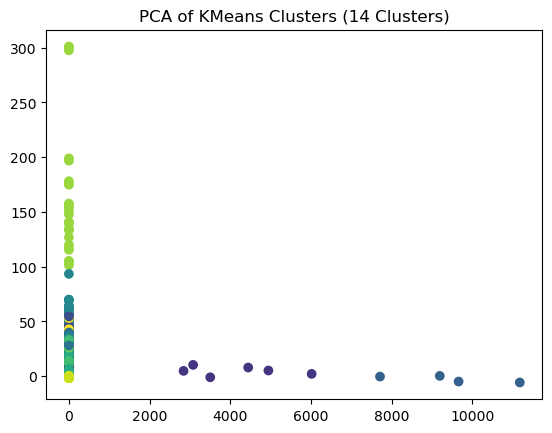

0.6686341


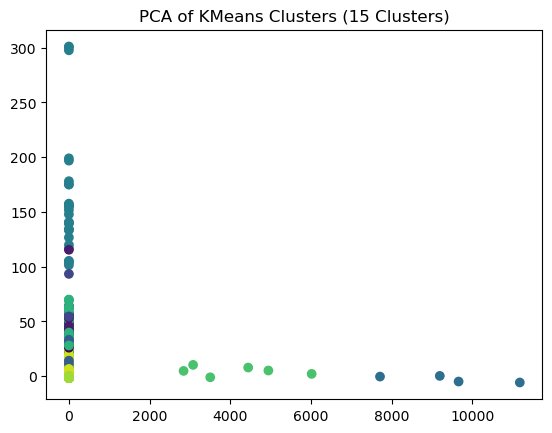

0.5072459


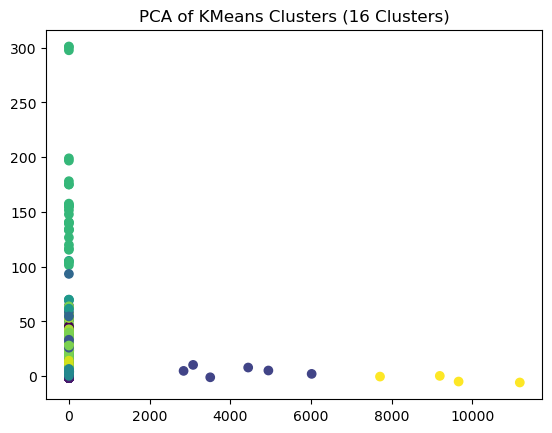

0.53716123


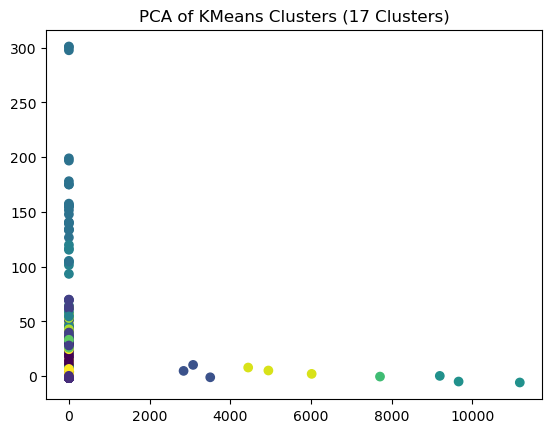

0.46831813


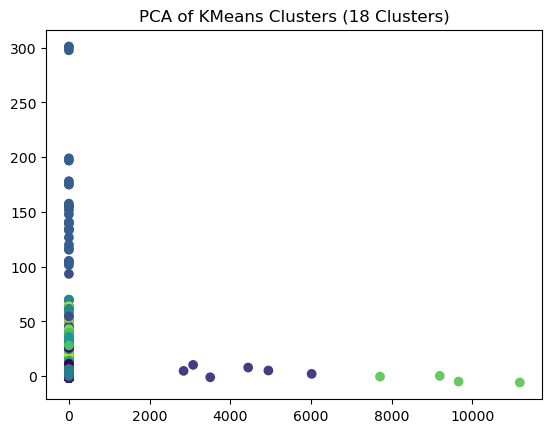

0.5114571


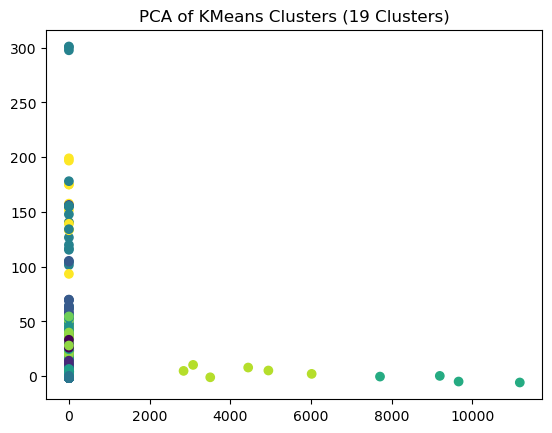

0.32172105


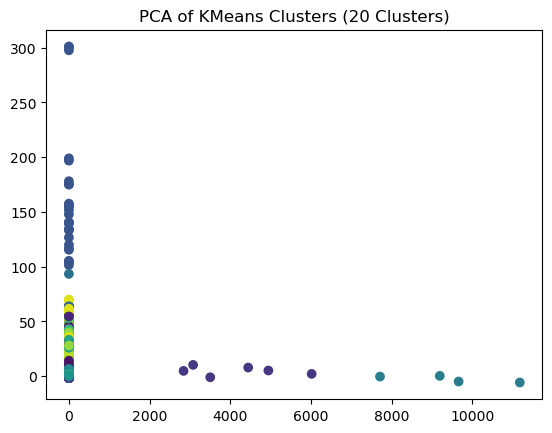

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
Labels_save=[];
for n_clusters in range(2, 21):
    # Run PSO-KMeans with the current number of clusters
    kmeans =  cuckoo_kmeans(tfidf_matrix_reduced, n_clusters)
    
    # Calculate metrics
    silhouette = silhouette_score(tfidf_matrix_reduced, kmeans.labels_)
    print(silhouette)
    davies_bouldin = davies_bouldin_score(tfidf_matrix_reduced, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(tfidf_matrix_reduced, kmeans.labels_)
    
    # Store metrics
    silhouette_scores.append(silhouette)
    davies_bouldin_scores.append(davies_bouldin)
    calinski_harabasz_scores.append(calinski_harabasz)
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(tfidf_matrix_reduced)

# Visualizing the clusters
    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans.labels_)
    plt.title(f'PCA of KMeans Clusters ({n_clusters} Clusters)')
    plt.show()

C:\Users\Devendra Nemade\AppData\Local\Temp\ipykernel_15340\1341984160.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Devendra Nemade\AppData\Local\Temp\ipykernel_15340\1341984160.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


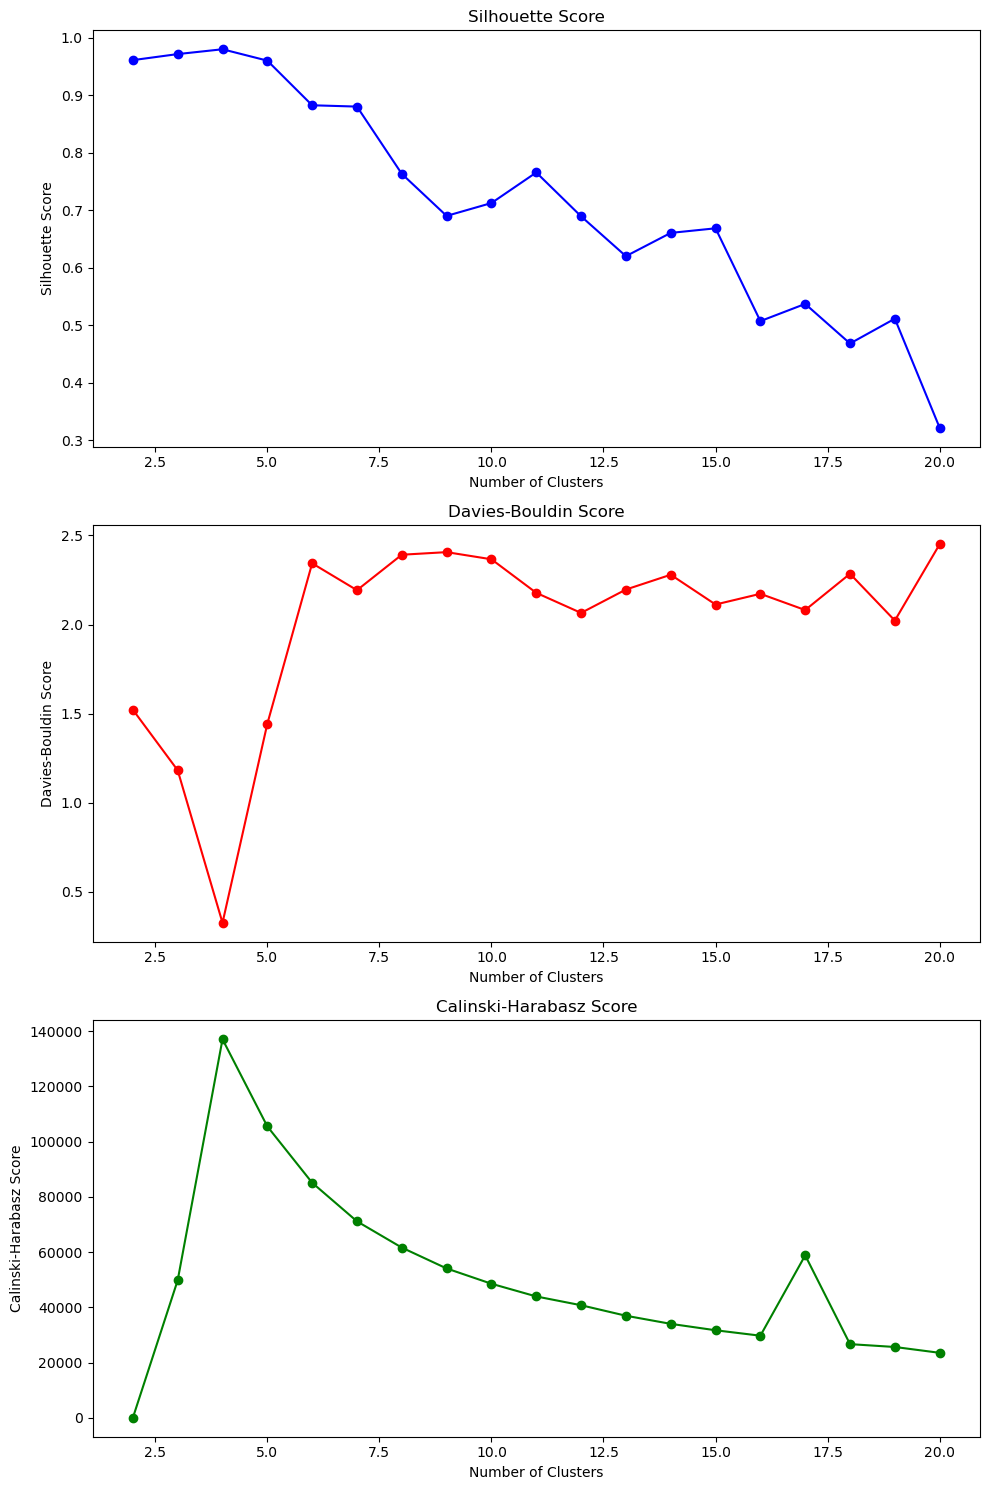

In [22]:
import matplotlib.pyplot as plt
# Plotting the metrics
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Silhouette Score
axs[0].plot(range(2, 21), silhouette_scores, marker='o', linestyle='-', color='blue')
axs[0].set_title('Silhouette Score')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Silhouette Score')
plt.savefig("Silhouette Score_News_countCuckoo-Kmeans.png")

# Davies-Bouldin Score
axs[1].plot(range(2, 21), davies_bouldin_scores, marker='o', linestyle='-', color='red')
axs[1].set_title('Davies-Bouldin Score')
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Davies-Bouldin Score')
plt.tight_layout()
plt.savefig("Davies-Bouldin Score_News_countCuckoo-Kmeans.png")
# Calinski-Harabasz Score
axs[2].plot(range(2, 21), calinski_harabasz_scores, marker='o', linestyle='-', color='green')
axs[2].set_title('Calinski-Harabasz Score')
axs[2].set_xlabel('Number of Clusters')
axs[2].set_ylabel('Calinski-Harabasz Score')
plt.tight_layout()
plt.savefig("Calinski-Harabasz Score_News_countCuckoo-Kmeans.png")
plt.tight_layout()
plt.show()

In [23]:
import pandas as pd
data = {'silhouette_scores':silhouette_scores,'davies_bouldin_scores': davies_bouldin_scores,
        'calinski_harabasz_scores': calinski_harabasz_scores}
df=pd.DataFrame(data,index=range(2, 21))
df

,silhouette_scores,davies_bouldin_scores,calinski_harabasz_scores
2,0.961105,1.521604,30.619786
3,0.971618,1.181558,49804.192599
4,0.980010,0.325246,137048.780332
5,0.960212,1.442798,105500.097867
6,0.882605,2.343761,85112.609257
7,0.880315,2.192809,71144.923095
8,0.763338,2.391972,61636.518390
9,0.690219,2.406500,54085.570516
10,0.712578,2.366416,48550.024591
11,0.765741,2.177930,43954.326407


In [24]:
df.to_csv('News_count_Cuckoo-Kmeans.csv')